## ML Anagram checker 

### Python Solution

In [85]:
from collections import Counter

def isAnagram4(s: str, t: str) -> bool:
    print("s: ", Counter(s))
    print("t: ", Counter(s))
    return  Counter(s) == Counter(t)

isAnagram4("anagram", "nagrama")

s:  Counter({'a': 3, 'n': 1, 'g': 1, 'r': 1, 'm': 1})
t:  Counter({'a': 3, 'n': 1, 'g': 1, 'r': 1, 'm': 1})


True

### Solution Using machine learning

In [86]:
import random

# 1. Generate data
def generate_anagrams(anagram_words, non_words, n_samples=1000):
    dataset = []
    total_items = len(anagram_words)
    
    for x in range(n_samples):
        
        # anagrams
        random_int = random.randint(0, total_items)
        word1 = anagram_words[random_int][0]
        word2 = ''.join(sorted(word1))
        combined = "".join(sorted(word1)+sorted(word2))
        dataset.append([sorted(word1) == sorted(word2), word1, word2, combined])
        
        # non anagrams
        random_int = random.randint(0, total_items)
        word2 = non_words[random_int][0]
        random_int = random.randint(0, total_items)
        word2_rand = non_words[random_int][0]
        combined = "".join(sorted(word2_rand)+sorted(word2))
        dataset.append([sorted(word2) == sorted(word2_rand), word2, word2_rand, combined])
        
        # non anagrams 2: we observed that the model was learning to identify anagrams based on the occurance of same letters
        word3 = word1[-3:]
        word4 = word1
        combined = "".join(sorted(word3)+sorted(word4))
        dataset.append([sorted(word3) == sorted(word4), word3, word4, combined])
    
    return dataset

# pairs, labels = generate_anagrams(n_samples=1000)
        

In [87]:
# load training data
import pandas as df
import csv
def load_csv(filepath):
    with open(filepath, newline='\n') as f:
        return list(csv.reader(f))

# Load training data
anagrams = load_csv('anagram_dictionary.csv')
non_anagrams = load_csv('wordlist.csv')

columns = ["IsAnagram", "FirstWord", "SecondWord", "Combined"]
labels = ["Non Anagrams", "Anagrams"]
dataset = generate_anagrams(anagrams, non_anagrams, n_samples=500)

df = df.DataFrame(dataset, columns=columns)
df[:10]

,IsAnagram,FirstWord,SecondWord,Combined
0,True,raggedy,adeggry,adeggryadeggry
1,False,crimple,camden,acdemnceilmpr
2,False,edy,raggedy,deyadeggry
3,True,nuncios,cinnosu,cinnosucinnosu
4,False,commendable,dietician,acdeiiintabcdeelmmno
5,False,ios,nuncios,ioscinnosu
6,True,videotaped,addeeioptv,addeeioptvaddeeioptv
7,False,dumb,cochlospermaceae,aaccceeehlmooprsbdmu
8,False,ped,videotaped,depaddeeioptv
9,True,subrogates,abegorsstu,abegorsstuabegorsstu


In [88]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize data, analyzer creates character tokens ,ngram_range allows vectorizer to include word pairs as individual words
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='char')

x = vectorizer.fit_transform(df['Combined'])
y = df['IsAnagram']

In [89]:
# Split data 50/50 for test/train
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, stratify=y)

In [90]:
from sklearn.linear_model import LogisticRegression

# Fit model using LR
lr_model = LogisticRegression(max_iter=1000, random_state=0)
lr_model.fit(x_train, y_train)
lr_model.score(x_test, y_test)

0.724

In [91]:
from sklearn.model_selection import cross_val_score

cross_val_score(lr_model, x, y, cv=5).mean()
# LR model does not really perform well, lets try other models

np.float64(0.7233333333333334)

In [92]:
# lets use gradient booster 
%matplotlib inline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay as cmd

# Fit model using GBC
gbc_model = GradientBoostingClassifier(random_state=0)
gbc_model.fit(x_train, y_train)

GradientBoostingClassifier(random_state=0)

In [93]:
# calculate the cross val score
cross_val_score(gbc_model, x, y, cv=5).mean()

np.float64(0.9813333333333333)

In [94]:
gbc_model.score(x_test, y_test)
# Our model is performing well with GBC

0.972

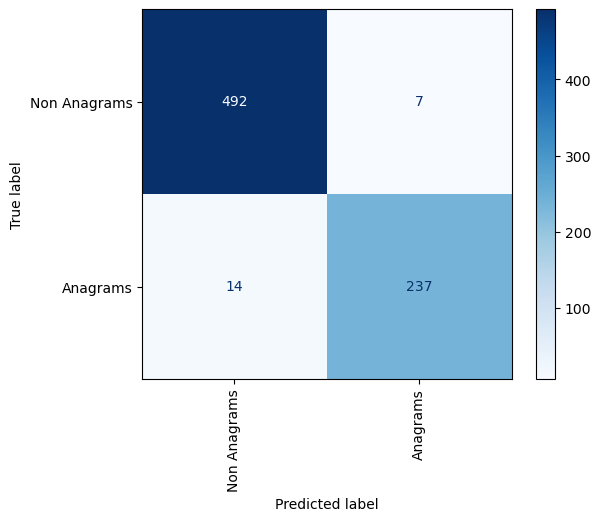

In [95]:
# plot the Confusion matrix diagram
cmd.from_estimator(gbc_model, x_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [96]:
# lets try the random forest classifier
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(random_state=0)
rfc_model.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

In [97]:
cross_val_score(rfc_model, x, y, cv=5).mean()

np.float64(0.958)

In [98]:
# check test score
rfc_model.score(x_test, y_test)

0.9226666666666666

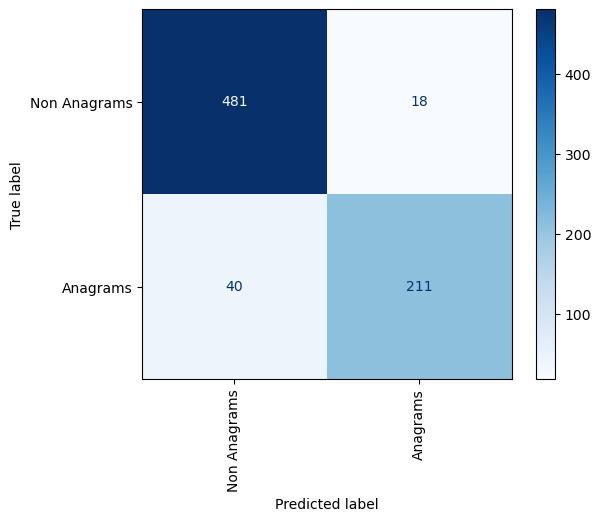

In [99]:
cmd.from_estimator(rfc_model, x_test, y_test, display_labels=labels, cmap='Blues', xticks_rotation='vertical')

In [100]:
# export model
import pickle

pickle.dump(gbc_model, open('anagram_model.pkl', 'wb'))


In [101]:
# predict 
def predict_anagram(word1: str, word2: str, model_file: str):
    
    word_combined = "".join(sorted(word1)+sorted(word2))

    transformed = vectorizer.transform([word_combined])
    model = pickle.load(open(model_file, 'rb'))
    prediction = model.predict(transformed)[0]
    
    print(prediction)

    if prediction:
        print(f"{word2} is an anagram of {word1}")
    else:
        print(f"{word2} is not an anagram of {word1}")


In [102]:
# Predict logic
predict_anagram("earth", "heart", "anagram_model.pkl")

True
heart is an anagram of earth


In [103]:
# Lets use a pipeline to combine vectorizer and model
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

x = df['Combined']
y = df['IsAnagram']
vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='char')

rfc_model = RandomForestClassifier(random_state=0)

rfc_pipeline = make_pipeline(vectorizer, rfc_model)
rfc_pipeline.fit(x, y)

pickle.dump(rfc_model, open('pipe_anagram_model.pkl', 'wb'))

In [104]:
# predict anagram using pipeline
predict_anagram("stop", "wes", "pipe_anagram_model.pkl")

False
wes is not an anagram of stop


In [105]:
predict_anagram("post", "stop", "pipe_anagram_model.pkl")

True
stop is an anagram of post
